# Full Data Plotting (Repo Decoders)

Use the current codebase decoders (Wiener, Wiener Cascade, Kalman, and optional neural nets) on the bundled datasets, then visualize metrics and traces. Adjust decoder lists and dataset choices in the config cell below.

In [ ]:
from pathlib import Path

import sys

import numpy as np

import matplotlib.pyplot as plt



project_root = Path("..").resolve()

if str(project_root) not in sys.path:

    sys.path.append(str(project_root))



from neural_decoding.data import load_dataset, bin_spikes, bin_output, prepare_train_test_split

from neural_decoding.evaluation.metrics import evaluate_decoder

from neural_decoding.visualization.plots import (

    plot_predictions,

    plot_decoder_comparison,

    plot_scatter_comparison,

)

from neural_decoding.models import WienerFilterDecoder, WienerCascadeDecoder, KalmanFilterDecoder

try:

    from neural_decoding.models import DenseNNDecoder, LSTMDecoder

except Exception:

    DenseNNDecoder = None

    LSTMDecoder = None



plt.rcParams["figure.dpi"] = 120

np.set_printoptions(precision=3, suppress=True)

ModuleNotFoundError: No module named 'neural_decoding'

## Configuration

Update dataset paths, binning parameters, and which decoders to run. The notebook automatically drops decoders that are unavailable (e.g., neural nets when TensorFlow is not installed).

In [ ]:
# Dataset paths

data_dir = project_root / "data" / "raw"

datasets = {

    "m1": data_dir / "m1_data_raw.mat",

    "hc": data_dir / "hc_data_raw.mat",

}

dataset_key = "m1"  # Choose which dataset to run



# Binning and splitting

bin_size = 0.05

bins_before = 0

bins_after = 0

bins_current = 1

test_size = 0.2

validation_size = 0.1

random_seed = 42



# Decoder factories (kept small to match the repo)

decoder_factories = {

    "wiener_filter": lambda: WienerFilterDecoder(),

    "wiener_cascade": lambda: WienerCascadeDecoder(degree=3),

    "kalman": lambda: KalmanFilterDecoder(noise_scale_c=1.0),

}



# Optional neural nets (only added if available)

if DenseNNDecoder is not None:

    decoder_factories["dense_nn"] = lambda: DenseNNDecoder(

        units=128, dropout_rate=0.25, num_epochs=10, batch_size=128, verbose=0

    )

if LSTMDecoder is not None:

    decoder_factories["lstm"] = lambda: LSTMDecoder(

        units=64, dropout_rate=0.25, num_epochs=30, batch_size=128, verbose=0

    )



selected_decoders = list(decoder_factories.keys())  # Trim this list to limit runs

## Helper Functions

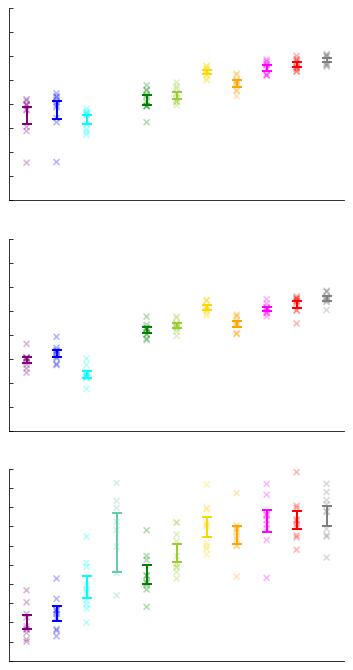

In [ ]:
from typing import Dict, Any, Tuple





def _get_end_time(spike_times, output_times) -> float:

    max_spike = max((np.max(neuron) if len(neuron) > 0 else 0.0 for neuron in spike_times))

    max_output = float(np.max(output_times)) if output_times.size else 0.0

    return min(max_spike, max_output)





def prepare_dataset(mat_path: Path) -> Dict[str, Any]:

    raw = load_dataset(mat_path)

    spike_times = raw["spike_times"]

    outputs = raw["outputs"]

    output_times = raw["output_times"]

    end_time = _get_end_time(spike_times, output_times)

    if end_time <= bin_size:

        raise ValueError("End time too short for binning; check the dataset and bin_size.")

    neural = bin_spikes(spike_times, bin_size, start_time=0.0, end_time=end_time)

    outputs_binned = bin_output(outputs, output_times, bin_size, start_time=0.0, end_time=end_time)

    X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_train_test_split(

        neural,

        outputs_binned,

        bins_before,

        bins_after,

        bins_current,

        test_size=test_size,

        validation_size=validation_size,

        random_seed=random_seed,

    )

    return {

        "X_train": X_train,

        "X_valid": X_valid,

        "X_test": X_test,

        "y_train": y_train,

        "y_valid": y_valid,

        "y_test": y_test,

        "time_indices": np.arange(y_test.shape[0]) * bin_size,

    }





def train_and_eval_decoder(name: str, factory, data: Dict[str, np.ndarray]) -> Tuple[Dict[str, Any], np.ndarray]:

    decoder = factory()

    decoder.fit(data["X_train"], data["y_train"])

    y_pred = decoder.predict(data["X_test"])

    metrics = evaluate_decoder(data["y_test"], y_pred, decoder_name=name)

    return metrics, y_pred





def get_active_decoders() -> Dict[str, Any]:

    return {k: v for k, v in decoder_factories.items() if k in selected_decoders}

## Run Decoders and Summaries

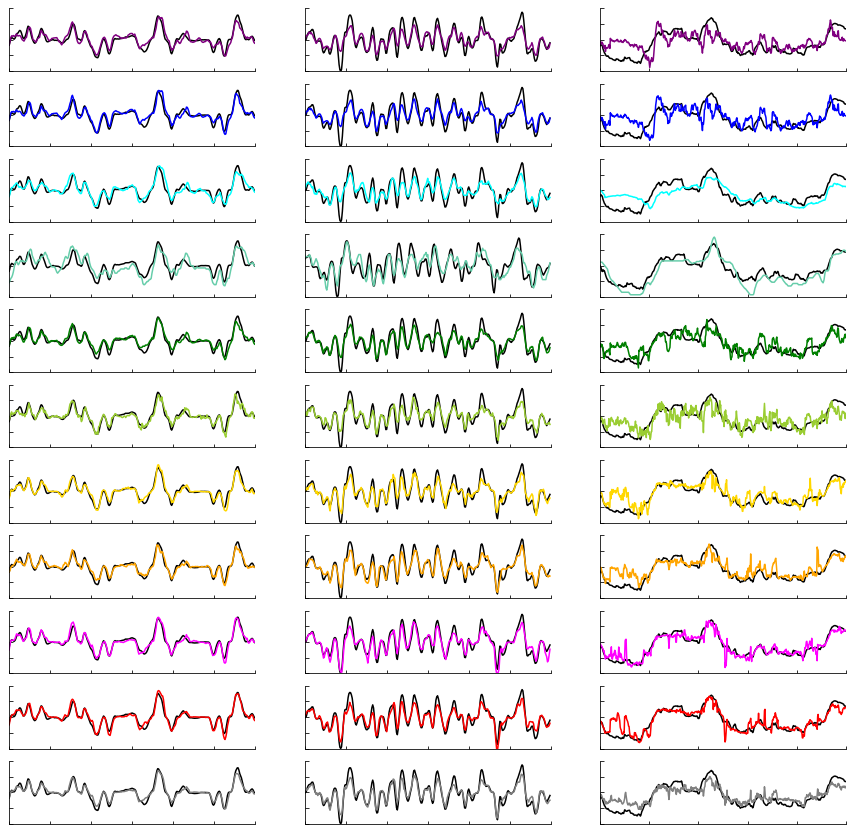

In [ ]:
active_decoders = get_active_decoders()

if not active_decoders:

    raise ValueError("No decoders selected/available.")



mat_path = datasets.get(dataset_key)

if mat_path is None:

    raise ValueError(f"Dataset key {dataset_key} not found. Available: {list(datasets)}")

if not mat_path.exists():

    raise FileNotFoundError(f"Data file missing: {mat_path}")



data = prepare_dataset(mat_path)



results = {}

predictions = {}

for name, factory in active_decoders.items():

    metrics, y_pred = train_and_eval_decoder(name, factory, data)

    results[name] = metrics

    predictions[name] = y_pred

    mean_r2 = float(np.mean(np.atleast_1d(metrics["r2"])))

    rho = float(np.mean(np.atleast_1d(metrics["pearson_correlation"])))

    print(f"{name}: R2={mean_r2:.3f}, rho={rho:.3f}")



mean_r2 = {name: float(np.mean(np.atleast_1d(m["r2"]))) for name, m in results.items()}

best_decoder = max(mean_r2, key=mean_r2.get)

print(f"Best decoder: {best_decoder}")



fig = plot_decoder_comparison(results, metric="r2", figsize=(8, 4))

plt.show()



# Stash for later cells

best_prediction = predictions[best_decoder]

y_test = data["y_test"]

time_indices = data["time_indices"]

In [ ]:
# Plot traces for the best-performing decoder (change to another key if desired)

decoder_to_plot = best_decoder

fig = plot_predictions(

    y_true=y_test,

    y_pred=predictions[decoder_to_plot],

    title=f"{decoder_to_plot} predictions vs truth",

    time_indices=time_indices,

    figsize=(12, 6),

)

plt.show()

## Optional: Scatter Comparison

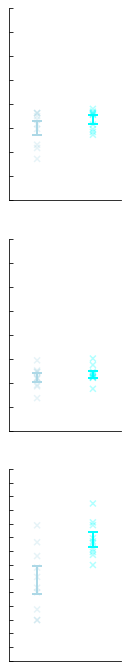

In [ ]:
scatter_output_idx = 0  # Change to inspect a different dimension

fig = plot_scatter_comparison(

    y_true=y_test,

    y_pred=predictions[decoder_to_plot],

    output_idx=scatter_output_idx,

    title=f"{decoder_to_plot} scatter",

    figsize=(5, 5),

)

plt.show()

In [ ]:
# Optional: persist the most recent figure

output_dir = project_root / "reports" / "figures"

output_dir.mkdir(parents=True, exist_ok=True)

fig.savefig(output_dir / f"{decoder_to_plot}_scatter.png", dpi=150)

print(f"Saved scatter plot to {output_dir}")